In [1]:
from keras.layers import Lambda, Input, Dense
from keras.models import Model
# from keras.datasets import mnist
from keras.losses import binary_crossentropy, categorical_crossentropy
from keras import backend as K
from keras.optimizers import Adam

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import roc_auc_score
from time import time
from scipy.spatial.distance import euclidean
from sklearn.metrics import average_precision_score
from scipy.stats import multivariate_normal as multi_norm

/Users/tradergllc/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Prepare Reality Mining Data

In [2]:
# Apps By Week
df = pd.read_csv('/Users/tradergllc/rsi/datasets/proc/reality-mining/txt/interim/appsByWeek-clean.txt', 
                 sep=', ', header=None, engine='python', dtype=str, names=['id', 'date', 'app', 'freq'])

In [3]:
df['app'].unique().shape

(206,)

In [4]:
# Clean app names
# for r in range(len(df.index)):
#     if df.iloc[r, 2].find(':') > -1:
#         print df.iloc[r]
#         df.iloc[r, 2] = 'Phone'

In [5]:
def convert_to_dict(df):
    data_dict = {}
    
    unique = list(df.iloc[:, 2].unique())
    
    date_list = [df.iloc[0, 1]]
    pid_date_list = [(df.iloc[0,0], df.iloc[0, 1])]
    
    data_dict[int(df.iloc[0,0])] = {}
    data_dict[int(df.iloc[0,0])][df.iloc[0, 1]] = np.zeros((len(unique),))
    data_dict[int(df.iloc[0,0])][df.iloc[0, 1]][unique.index(df.iloc[0, 2])] = 1
        
    for r in range(1, len(df.index)):
        pid = int(df.iloc[r, 0])
        if pid not in data_dict.keys():
            data_dict[pid] = {}        
        
        if (df.iloc[r, 0], df.iloc[r, 1]) in pid_date_list:
            data_dict[pid][df.iloc[r, 1]][unique.index(df.iloc[r, 2])] = 1 #df.iloc[r, 3]
        else:
            date_list.append(df.iloc[r, 1])
            pid_date_list.append((df.iloc[r, 0], df.iloc[r, 1]))
            
            data_dict[pid][df.iloc[r, 1]] = np.zeros((len(unique),))
            data_dict[pid][df.iloc[r, 1]][unique.index(df.iloc[r, 2])] = 1
                        
    return data_dict, unique

In [6]:
data_dict, unique = convert_to_dict(df)

In [7]:
def dict_to_np_array(d):
    vector_list = []
    gt_pid = []
    for pid in d.keys():
        for date in d[pid].keys():
#             print pid, date
            vector_list.append(d[pid][date])
            gt_pid.append(d.keys().index(pid))
    return np.stack(vector_list), np.array(gt_pid)

In [8]:
x_train_full, y_train = dict_to_np_array(data_dict)
print x_train_full.shape, y_train.shape

(1911, 206) (1911,)


In [9]:
y_train

array([ 0,  0,  0, ..., 87, 87, 87])

In [10]:
x_train_full.shape

(1911, 206)

In [11]:
x_train = x_train_full.copy()
# for i in np.where(x_train_full.sum(axis=0) > 1)[0][::-1]:
# x_train = np.delete(x_train_full, np.where(x_train_full.sum(axis=0) == 1)[0], axis=1)
# x_train = x_train_full[:, x_train_full.sum(axis=0).argsort()[::-1][:75*75]].reshape((-1, 75*75))

In [12]:
print x_train.shape

(1911, 206)


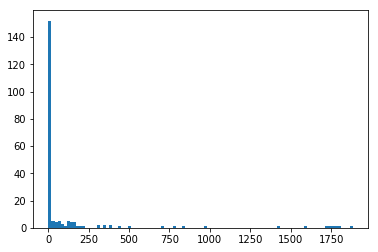

In [13]:
plt.hist(x_train.sum(axis=0), bins=100)
plt.show()

# n = 10  # how many digits we will display
# choice = np.random.choice(range(len(x_train)), n, replace=False)
# plt.figure(figsize=(20, 4))
# for i in range(n):
#     # display original
#     ax = plt.subplot(1, n, i + 1)
#     plt.imshow(x_train[choice[i], :200])
#     plt.gray()
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)
# plt.show()

### Train VAE

In [14]:
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.

    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)

    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [15]:
original_dim = x_train.shape[-1]

# network parameters
input_shape = (original_dim, )
intermediate_dim = 100
# inter_dim_2 = 250
latent_dim = 16

batch_size = 128
# epochs = 50

In [16]:
inputs = Input(shape=(original_dim,), name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

reconstruction_loss = categorical_crossentropy(inputs,outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer=Adam(lr=0.001, decay=1.0e-5))

In [17]:
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 206)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 100)          20700       encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 16)           1616        dense_1[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 16)           1616        dense_1[0][0]                    
__________________________________________________________________________________________________
z (Lambda)

In [18]:
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 206)               0         
_________________________________________________________________
encoder (Model)              [(None, 16), (None, 16),  23932     
_________________________________________________________________
decoder (Model)              (None, 206)               22506     
Total params: 46,438
Trainable params: 46,438
Non-trainable params: 0
_________________________________________________________________


In [19]:
vae.fit(x_train[np.random.choice(range(x_train.shape[0]), 20, replace=False)], epochs=1000, batch_size=batch_size)

Epoch 1/1000
20/20 [==============================] - 0s 19ms/step - loss: 12932.1787
Epoch 2/1000
20/20 [==============================] - 0s 166us/step - loss: 12867.8828
Epoch 3/1000
20/20 [==============================] - 0s 177us/step - loss: 12832.3877
Epoch 4/1000
20/20 [==============================] - 0s 164us/step - loss: 12763.5352
Epoch 5/1000
20/20 [==============================] - 0s 171us/step - loss: 12711.5723
Epoch 6/1000
20/20 [==============================] - 0s 182us/step - loss: 12660.2002
Epoch 7/1000
20/20 [==============================] - 0s 283us/step - loss: 12652.8125
Epoch 8/1000
20/20 [==============================] - 0s 166us/step - loss: 12536.0176
Epoch 9/1000
20/20 [==============================] - 0s 234us/step - loss: 12508.0801
Epoch 10/1000
20/20 [==============================] - 0s 159us/step - loss: 12447.7764
Epoch 11/1000
20/20 [==============================] - 0s 194us/step - loss: 12308.7734
Epoch 12/1000
20/20 [=====================

Epoch 95/1000
20/20 [==============================] - 0s 203us/step - loss: 7683.2290
Epoch 96/1000
20/20 [==============================] - 0s 185us/step - loss: 7720.4307
Epoch 97/1000
20/20 [==============================] - 0s 176us/step - loss: 7660.9971
Epoch 98/1000
20/20 [==============================] - 0s 195us/step - loss: 7678.7734
Epoch 99/1000
20/20 [==============================] - 0s 375us/step - loss: 7582.1318
Epoch 100/1000
20/20 [==============================] - 0s 186us/step - loss: 7622.3608
Epoch 101/1000
20/20 [==============================] - 0s 270us/step - loss: 7650.4033
Epoch 102/1000
20/20 [==============================] - 0s 155us/step - loss: 7669.0078
Epoch 103/1000
20/20 [==============================] - 0s 206us/step - loss: 7651.0054
Epoch 104/1000
20/20 [==============================] - 0s 162us/step - loss: 7585.9287
Epoch 105/1000
20/20 [==============================] - 0s 206us/step - loss: 7537.6548
Epoch 106/1000
20/20 [===============

20/20 [==============================] - 0s 147us/step - loss: 6999.4360
Epoch 189/1000
20/20 [==============================] - 0s 134us/step - loss: 7029.6992
Epoch 190/1000
20/20 [==============================] - 0s 169us/step - loss: 6999.1187
Epoch 191/1000
20/20 [==============================] - 0s 336us/step - loss: 7029.3462
Epoch 192/1000
20/20 [==============================] - 0s 215us/step - loss: 7003.0830
Epoch 193/1000
20/20 [==============================] - 0s 200us/step - loss: 7008.4814
Epoch 194/1000
20/20 [==============================] - 0s 261us/step - loss: 6997.1182
Epoch 195/1000
20/20 [==============================] - 0s 449us/step - loss: 7008.4390
Epoch 196/1000
20/20 [==============================] - 0s 146us/step - loss: 6985.7666
Epoch 197/1000
20/20 [==============================] - 0s 205us/step - loss: 6985.5459
Epoch 198/1000
20/20 [==============================] - 0s 222us/step - loss: 6991.4326
Epoch 199/1000
20/20 [=========================

Epoch 282/1000
20/20 [==============================] - 0s 149us/step - loss: 6669.5845
Epoch 283/1000
20/20 [==============================] - 0s 186us/step - loss: 6667.4546
Epoch 284/1000
20/20 [==============================] - 0s 176us/step - loss: 6670.9399
Epoch 285/1000
20/20 [==============================] - 0s 229us/step - loss: 6668.1104
Epoch 286/1000
20/20 [==============================] - 0s 245us/step - loss: 6672.1172
Epoch 287/1000
20/20 [==============================] - 0s 229us/step - loss: 6662.1616
Epoch 288/1000
20/20 [==============================] - 0s 281us/step - loss: 6663.0547
Epoch 289/1000
20/20 [==============================] - 0s 162us/step - loss: 6655.2373
Epoch 290/1000
20/20 [==============================] - 0s 181us/step - loss: 6661.1187
Epoch 291/1000
20/20 [==============================] - 0s 336us/step - loss: 6659.6748
Epoch 292/1000
20/20 [==============================] - 0s 145us/step - loss: 6654.6655
Epoch 293/1000
20/20 [==========

20/20 [==============================] - 0s 231us/step - loss: 6578.0811
Epoch 376/1000
20/20 [==============================] - 0s 176us/step - loss: 6574.1484
Epoch 377/1000
20/20 [==============================] - 0s 192us/step - loss: 6568.9751
Epoch 378/1000
20/20 [==============================] - 0s 337us/step - loss: 6570.5142
Epoch 379/1000
20/20 [==============================] - 0s 208us/step - loss: 6571.6748
Epoch 380/1000
20/20 [==============================] - 0s 247us/step - loss: 6574.3711
Epoch 381/1000
20/20 [==============================] - 0s 145us/step - loss: 6570.0615
Epoch 382/1000
20/20 [==============================] - 0s 182us/step - loss: 6569.1406
Epoch 383/1000
20/20 [==============================] - 0s 173us/step - loss: 6571.1436
Epoch 384/1000
20/20 [==============================] - 0s 200us/step - loss: 6566.2646
Epoch 385/1000
20/20 [==============================] - 0s 298us/step - loss: 6572.0664
Epoch 386/1000
20/20 [=========================

Epoch 469/1000
20/20 [==============================] - 0s 196us/step - loss: 6542.8340
Epoch 470/1000
20/20 [==============================] - 0s 231us/step - loss: 6547.2910
Epoch 471/1000
20/20 [==============================] - 0s 243us/step - loss: 6545.2891
Epoch 472/1000
20/20 [==============================] - 0s 209us/step - loss: 6545.0933
Epoch 473/1000
20/20 [==============================] - 0s 533us/step - loss: 6542.8721
Epoch 474/1000
20/20 [==============================] - 0s 206us/step - loss: 6540.5361
Epoch 475/1000
20/20 [==============================] - 0s 174us/step - loss: 6546.6084
Epoch 476/1000
20/20 [==============================] - 0s 407us/step - loss: 6543.5752
Epoch 477/1000
20/20 [==============================] - 0s 243us/step - loss: 6546.3711
Epoch 478/1000
20/20 [==============================] - 0s 141us/step - loss: 6544.0342
Epoch 479/1000
20/20 [==============================] - 0s 199us/step - loss: 6543.2344
Epoch 480/1000
20/20 [==========

20/20 [==============================] - 0s 201us/step - loss: 6470.7007
Epoch 563/1000
20/20 [==============================] - 0s 271us/step - loss: 6471.5679
Epoch 564/1000
20/20 [==============================] - 0s 150us/step - loss: 6475.6377
Epoch 565/1000
20/20 [==============================] - 0s 253us/step - loss: 6470.3799
Epoch 566/1000
20/20 [==============================] - 0s 204us/step - loss: 6466.2969
Epoch 567/1000
20/20 [==============================] - 0s 149us/step - loss: 6469.4053
Epoch 568/1000
20/20 [==============================] - 0s 304us/step - loss: 6473.4199
Epoch 569/1000
20/20 [==============================] - 0s 176us/step - loss: 6468.2041
Epoch 570/1000
20/20 [==============================] - 0s 276us/step - loss: 6467.7036
Epoch 571/1000
20/20 [==============================] - 0s 195us/step - loss: 6466.9336
Epoch 572/1000
20/20 [==============================] - 0s 151us/step - loss: 6470.6328
Epoch 573/1000
20/20 [=========================

Epoch 656/1000
20/20 [==============================] - 0s 313us/step - loss: 6440.5049
Epoch 657/1000
20/20 [==============================] - 0s 244us/step - loss: 6439.0493
Epoch 658/1000
20/20 [==============================] - 0s 300us/step - loss: 6438.1631
Epoch 659/1000
20/20 [==============================] - 0s 208us/step - loss: 6438.1807
Epoch 660/1000
20/20 [==============================] - 0s 135us/step - loss: 6441.1118
Epoch 661/1000
20/20 [==============================] - 0s 289us/step - loss: 6441.2139
Epoch 662/1000
20/20 [==============================] - 0s 169us/step - loss: 6438.7334
Epoch 663/1000
20/20 [==============================] - 0s 245us/step - loss: 6439.1636
Epoch 664/1000
20/20 [==============================] - 0s 132us/step - loss: 6435.3013
Epoch 665/1000
20/20 [==============================] - 0s 218us/step - loss: 6438.9619
Epoch 666/1000
20/20 [==============================] - 0s 175us/step - loss: 6436.7153
Epoch 667/1000
20/20 [==========

20/20 [==============================] - 0s 168us/step - loss: 6423.8379
Epoch 750/1000
20/20 [==============================] - 0s 535us/step - loss: 6422.8364
Epoch 751/1000
20/20 [==============================] - 0s 261us/step - loss: 6426.1499
Epoch 752/1000
20/20 [==============================] - 0s 173us/step - loss: 6422.6572
Epoch 753/1000
20/20 [==============================] - 0s 157us/step - loss: 6424.7393
Epoch 754/1000
20/20 [==============================] - 0s 143us/step - loss: 6422.0332
Epoch 755/1000
20/20 [==============================] - 0s 162us/step - loss: 6419.7666
Epoch 756/1000
20/20 [==============================] - 0s 172us/step - loss: 6422.4517
Epoch 757/1000
20/20 [==============================] - 0s 140us/step - loss: 6424.6904
Epoch 758/1000
20/20 [==============================] - 0s 190us/step - loss: 6422.6523
Epoch 759/1000
20/20 [==============================] - 0s 462us/step - loss: 6418.3257
Epoch 760/1000
20/20 [=========================

Epoch 843/1000
20/20 [==============================] - 0s 174us/step - loss: 6397.4482
Epoch 844/1000
20/20 [==============================] - 0s 377us/step - loss: 6394.1187
Epoch 845/1000
20/20 [==============================] - 0s 191us/step - loss: 6393.2900
Epoch 846/1000
20/20 [==============================] - 0s 258us/step - loss: 6394.3589
Epoch 847/1000
20/20 [==============================] - 0s 197us/step - loss: 6396.7183
Epoch 848/1000
20/20 [==============================] - 0s 352us/step - loss: 6395.6045
Epoch 849/1000
20/20 [==============================] - 0s 134us/step - loss: 6398.2017
Epoch 850/1000
20/20 [==============================] - 0s 293us/step - loss: 6395.0688
Epoch 851/1000
20/20 [==============================] - 0s 194us/step - loss: 6395.7285
Epoch 852/1000
20/20 [==============================] - 0s 213us/step - loss: 6394.5542
Epoch 853/1000
20/20 [==============================] - 0s 493us/step - loss: 6394.9751
Epoch 854/1000
20/20 [==========

20/20 [==============================] - 0s 307us/step - loss: 6387.6704
Epoch 937/1000
20/20 [==============================] - 0s 254us/step - loss: 6388.0986
Epoch 938/1000
20/20 [==============================] - 0s 310us/step - loss: 6382.1704
Epoch 939/1000
20/20 [==============================] - 0s 197us/step - loss: 6385.8340
Epoch 940/1000
20/20 [==============================] - 0s 251us/step - loss: 6385.3452
Epoch 941/1000
20/20 [==============================] - 0s 250us/step - loss: 6388.8564
Epoch 942/1000
20/20 [==============================] - 0s 214us/step - loss: 6384.7803
Epoch 943/1000
20/20 [==============================] - 0s 274us/step - loss: 6387.2217
Epoch 944/1000
20/20 [==============================] - 0s 260us/step - loss: 6383.1865
Epoch 945/1000
20/20 [==============================] - 0s 199us/step - loss: 6382.8799
Epoch 946/1000
20/20 [==============================] - 0s 155us/step - loss: 6385.3652
Epoch 947/1000
20/20 [=========================

In [111]:
# np.save('encoder-bluetoothByWeek.npy', encoder.get_weights())
# np.save('decoder-bluetoothByWeek.npy', decoder.get_weights())

In [20]:
encoded_imgs = encoder.predict(x_train)
decoded_imgs = decoder.predict(encoded_imgs[2])

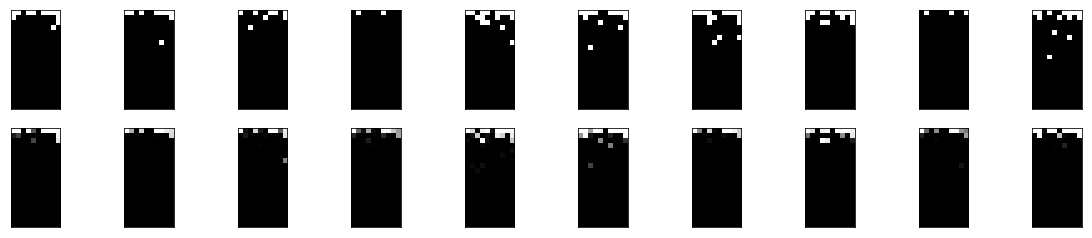

In [21]:
n = 10  # how many digits we will display
choice = np.random.choice(range(len(x_train)), n, replace=False)
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_train[choice[i], :200].reshape(20, 10))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[choice[i], :200].reshape(20, 10))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

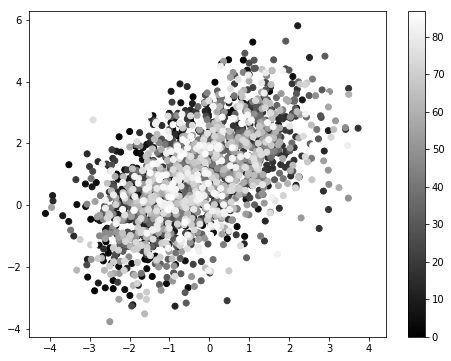

In [22]:
x_test_encoded = encoder.predict(x_train, batch_size=batch_size)
x_test_encoded = np.array(x_test_encoded)
plt.figure(figsize=(8, 6))
plt.scatter(x_test_encoded[2, :, 0], x_test_encoded[2, :, 1], c=y_train)
plt.colorbar()
plt.show()

In [23]:
mean = np.mean(x_test_encoded[0], axis=0)
print mean

std = np.std(x_test_encoded[0], axis=0)
print std

[-0.3644161   0.8334264   0.9951286   1.0925364  -1.0441831  -1.3882598
 -0.79218286 -1.3439208  -1.8388373   1.1318918   0.20334983  0.6716485
  1.0245111   0.09383725 -0.9853194   0.99709237]
[1.2603948  1.4620796  0.7654928  1.1491565  1.2182542  0.5989108
 0.92797834 0.8198461  0.9441989  0.8270418  1.4124835  1.4303467
 0.50257564 1.5698624  0.53387725 1.2427092 ]


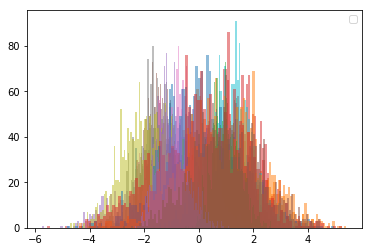

In [24]:
for i in range(len(std)):
    plt.hist(x_test_encoded[0, :, i], bins=100, alpha=0.5)

# plt.axvline(mean[0], color='green', linestyle='dashed', linewidth=1)
# plt.axvline(mean[1], color='red', linestyle='dashed', linewidth=1)

plt.legend()
plt.show()

In [25]:
x_test_encoded[0].shape

(1911, 16)

In [29]:
cov = np.cov(x_test_encoded[0].transpose())
# print cov

In [27]:
cov.shape

(16, 16)

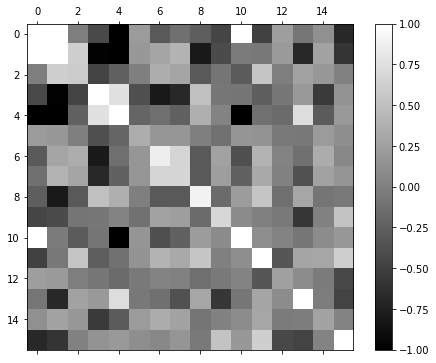

In [28]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
cax = ax.matshow(cov, vmin=-1, vmax=1)
fig.colorbar(cax)
# ticks = np.arange(0,32,1)
# ax.set_xticks(ticks)
# ax.set_yticks(ticks)
# ax.set_xticklabels(names)
# ax.set_yticklabels(names)
plt.show()

### Apply Generative Probabilistic Model

In [177]:
N_SINGLETONS = 65
N_PAIRS = 5

In [178]:
np.unique(y_train)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87])

In [179]:
singletons = np.random.choice(range(y_train.max() + 1), N_SINGLETONS, replace=False)
# pairs = np.random.choice( )
print singletons

[68 18 24 10 34 33 70 38 17  7 62 22 63 65 19 86 58 11 73 27 14 77 26 12
 40 74  4 49 54 28 48 84 44 35 79 21  3 80 55 31 78  0 37 69 81  8 52 42
 45 64 59 60 51  5  9 36 30 76 83 20 39 67 47 56 82]


In [180]:
remaining_idx = []
for i in np.arange(y_train.max() + 1):
    if i not in singletons:
        remaining_idx.append(i)
print remaining_idx

[1, 2, 6, 13, 15, 16, 23, 25, 29, 32, 41, 43, 46, 50, 53, 57, 61, 66, 71, 72, 75, 85, 87]


In [181]:
pairs = np.random.choice(remaining_idx, N_PAIRS, replace=False)
print pairs

[66  2 32 46 50]


In [182]:
vec_list = []
labels = []
GT_POS_PAIRS = []

pid_list = data_dict.keys()

for p in range(len(pairs)):
    pid = pid_list[pairs[p]]
#     print pid
    w1, w2 = np.random.choice(data_dict[pid].keys(), 2)
#     print w1, w2
    app_vec1, app_vec2 = data_dict[pid][w1], data_dict[pid][w2]
    
    vec_list.append(app_vec1)
    vec_list.append(app_vec2)
    
    labels.append(p + 1)
    labels.append(p + 1)
    GT_POS_PAIRS.append((2* p, 2* p + 1))

for s in singletons:
    pid = pid_list[s]
    w = np.random.choice(data_dict[pid].keys(), 1)
#     print pid
#     print w
    app_vec = data_dict[pid][w[0]]
    vec_list.append(app_vec)
    labels.append(0)

In [183]:
vec_list = np.array(vec_list)
# vec_list = vec_list[:, x_train_full.sum(axis=0).argsort()[::-1][:75*75]].reshape((-1, 75*75))

In [184]:
test_encoded_imgs = encoder.predict(vec_list)
test_decoded_imgs = decoder.predict(test_encoded_imgs[2])

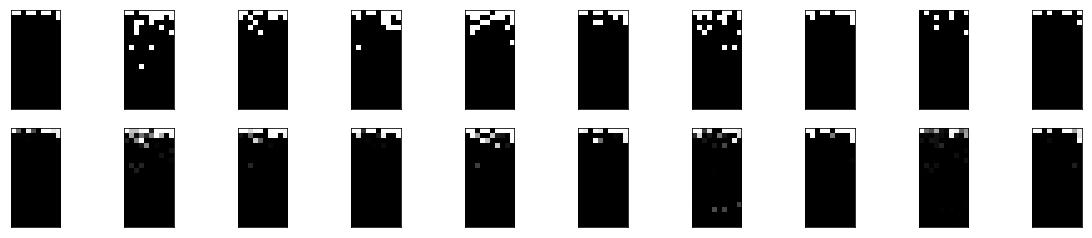

In [185]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(vec_list[i, :200].reshape(20, 10))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(test_decoded_imgs[i, :200].reshape(20, 10))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [186]:
points = encoder.predict(np.array(vec_list))[2]

In [187]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2).fit_transform(points)

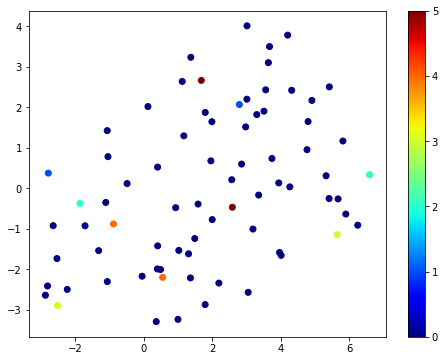

In [188]:
plt.figure(figsize=(8, 6))
plt.scatter(tsne[:, 0], tsne[:, 1], c=labels, cmap='jet')
plt.colorbar()
plt.show()

In [189]:
N_DIM = len(points.shape)
test_mean = np.mean(points, axis=0)
print test_mean
sigma = np.std(points)
std_axis = np.std(points, axis=0)
print std_axis
print sigma

[-0.50896084  0.6712214   0.9914934   1.352001   -0.9318613  -1.4828904
 -0.9720632  -1.4976969  -1.7337353   1.0586269   0.2754354   0.62723875
  0.9616208   0.34809196 -1.1436626   0.8790167 ]
[1.2843612  1.5675957  0.7907435  1.1908388  1.2428614  0.7756322
 0.94770575 0.8397354  0.9461807  0.9698731  1.2963636  1.3774675
 0.8723612  1.7035625  0.7509271  1.4210613 ]
1.5608892


In [190]:
nu = 0.1

In [191]:
t = (np.ones(std_axis.shape) * nu) / std_axis
# dis_var = np.matmul(t.transpose(), cov)

In [192]:
dis_var = np.diag(t)
# print dis_var

In [193]:
# cov = np.cov(points.transpose())

In [194]:
# cov

In [195]:
start = time()

LR_arr = []
LR_idx = []

dist_matrix = np.zeros((points.shape[0], points.shape[0]))
adj_matrix = np.zeros((points.shape[0], points.shape[0]))

for i in np.arange(points.shape[0]):
    for j in np.arange(i + 1, points.shape[0]):
        midpoint = 0.5 * (points[i] + points[j])
        
        m = euclidean(midpoint, test_mean)
        d = euclidean(0.5* (points[i] - points[j]), np.zeros(midpoint.shape))
        
        m_prime = m / sigma
        d_prime = d / sigma
        t = nu / sigma
        
        LR = np.power(0.5/t, N_DIM)* np.exp(0.5*(np.power(m_prime,2)+ np.power(d_prime,2)*(2- np.power(t,-2))))
        LR_arr.append(LR)
        dist_matrix[i, j] = LR
        
#         dis = 0.5* (points[i] - points[j])
#         pdf_mid = multi_norm.pdf(midpoint, mean=mean, cov=cov, allow_singular=True)
#         pdf_dis = multi_norm.pdf(dis, mean=np.zeros(dis.shape), cov=dis_var, allow_singular=True)
#         pdf_x_i = multi_norm.pdf(points[i], mean=mean, cov=cov, allow_singular=True)
#         pdf_x_j = multi_norm.pdf(points[j], mean=mean, cov=cov, allow_singular=True)
#         LR = pdf_mid * pdf_dis / (pdf_x_i*pdf_x_j)
#         LR_arr.append(LR)
#         dist_matrix[i, j] = LR
        
        if (i, j) in GT_POS_PAIRS:
            LR_idx.append(True)
            adj_matrix[i, j] = 1
        else:
            LR_idx.append(False)
            adj_matrix[i, j] = 0
            
print 'time elapsed: %f s' % (time() - start)

LR_arr = np.array(LR_arr)
LR_idx = np.array(LR_idx)

time elapsed: 0.275863 s


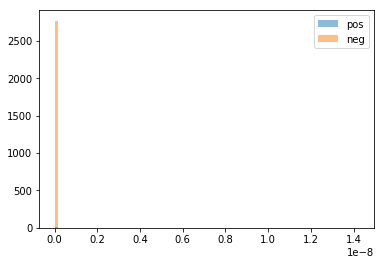

In [196]:
bins = np.linspace(LR_arr.min(), LR_arr.max(), 100)

plt.hist(LR_arr[LR_idx], bins, alpha=0.5, label='pos')
plt.hist(LR_arr[LR_idx == False], bins, alpha=0.5, label='neg')
plt.legend(loc='upper right')
plt.show()

In [197]:
print roc_auc_score(y_true=LR_idx, y_score=LR_arr)

0.4356678700361011


In [75]:
dist_matrix = dist_matrix + dist_matrix.transpose()
print dist_matrix

[[0.00000000e+000 4.93595301e+002 0.00000000e+000 ... 5.81601355e-172
  4.17656960e-163 1.69624878e-308]
 [4.93595301e+002 0.00000000e+000 0.00000000e+000 ... 4.57121213e-161
  1.66047308e-152 3.24742988e-295]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 1.55352044e-082
  5.11304976e-088 2.02158273e-019]
 ...
 [5.81601355e-172 4.57121213e-161 1.55352044e-082 ... 0.00000000e+000
  2.14621988e+002 4.97468585e-020]
 [4.17656960e-163 1.66047308e-152 5.11304976e-088 ... 2.14621988e+002
  0.00000000e+000 4.41784349e-023]
 [1.69624878e-308 3.24742988e-295 2.02158273e-019 ... 4.97468585e-020
  4.41784349e-023 0.00000000e+000]]


In [77]:
adj_matrix = adj_matrix + adj_matrix.transpose()
print adj_matrix

[[0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [93]:
rank = [1,5]

for r in rank:
    hit = 0
    tot = 0.0
    
    for i in np.where(adj_matrix == 1)[0]:
        idx = np.argsort(dist_matrix[i])[::-1]
        if 1 in adj_matrix[i, idx][:r]:
            hit += 1
        tot += 1
    
    print 'rank %d: %f' % (r, hit / tot)

rank 1: 0.700000
rank 5: 1.000000


In [89]:
AP_list = []
for i in np.where(adj_matrix == 1)[0]:
    ap = average_precision_score(y_true=adj_matrix[i], y_score=dist_matrix[i])
    AP_list.append(ap)
print 'mAP: %f' % (np.mean(AP_list))

mAP: 0.816667
